# Probabilistic Programming to break CAPTCHAS

Captchas are puzzles usually given as part of a verification procedure to ensure a internet user is indeed a human and not a bit. It involves identifying a string of letters (or numbers)


In this example we will write a probabilistic CAPTCHA generator and instrument it using the probabilistic programming library `pyprob` in order to run amortized inference.

First, we import some basic libraries we will need later on.

In [1]:
%matplotlib inline
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

import pyprob
import pyprob.distributions
import IPython

from PIL import Image, ImageFilter, ImageDraw, ImageFont


## Writing a Generator

Here we use the `Pillow` library to write a generator. This is a good example how probabilistic programs allow you use general purpose host languages (in this case Python, but could also be C++) with all their nice libraries, instead of restricting you to a statistical modeling framework (try writing this in RooFit :) )

In [2]:
# prepare the set of letters from which we 

alphabetorder = list('abcdefghijklmnopqrstuvw')
alphabet = dict(zip(range(len(alphabetorder)),alphabetorder))


def message_to_picture(width, height, message, blur):
    canvas = Image.new('L', (width, height), "white")
    font = ImageFont.load_default()
    ImageDraw.Draw(canvas).text((2,0), message, 'black', font)
    canvas = canvas.filter(ImageFilter.GaussianBlur(blur))
    d = np.asarray(list(canvas.getdata()), dtype = np.float)
    return d

def random_captcha(width, height, blur = 0.5):
    letter_distr = pyprob.distributions.Categorical([1/len(alphabet)]*len(alphabet))
    length = 3
    word =  ''.join([alphabet[letter_distr.sample().item()] for i in range(length)])
    d = message_to_picture(width, height, word,blur)
    return word, torch.tensor(d, dtype = torch.float).view(-1)/255-0.5

def likelihoood(observation,eps):
    lhood = pyprob.distributions.Normal(observation,eps*torch.ones(observation.shape))
    return lhood

# An Example CAPTCHA

Note that our captcha generator is very un-sophisticated, but it has the correct components: sampling latters, adding some blur, etc...

Let's generate a CAPTCHA to see how it looks

Text(0.5, 1.0, 'ground truth: ian')

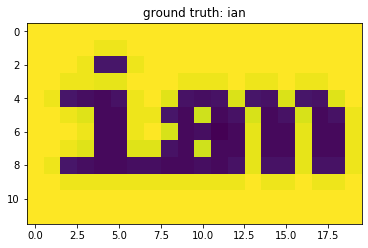

In [3]:
word, img = random_captcha(20,12, blur = 0.2)
plt.imshow(img.reshape(12,20))
plt.title('ground truth: {}'.format(word))

... and another one

Text(0.5, 1.0, 'ground truth: ckm')

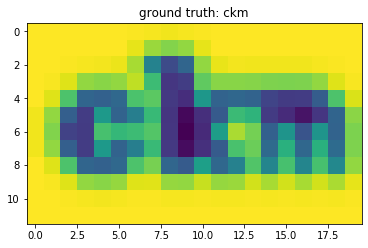

In [4]:
word, img = random_captcha(20,12, blur = 0.7)
plt.imshow(img.reshape(12,20))
plt.title('ground truth: {}'.format(word))

# Integrating into `pyprob`

Now we will see how we integrate this existing generative model into `pyprob`

In `pyprob` we only need to write a `forward()` method and inherit frmo the `Model` class. So integrating it is straight forward!

In the end we want to `observe`  the resulting image (we allow the pixel values of the generated image to be sampled frmo the mean determined by the latent rendered image)

In [5]:
import math
import pyprob
from pyprob import Model
from pyprob.distributions import Normal

class CaptchaModel(Model):
    def __init__(self):
        super().__init__(name="CAPTCHA model") # give the model a name

    def forward(self): # Needed to specifcy how the generative model is run forward
        mu = pyprob.sample(pyprob.distributions.Normal(0,1))
        blur = pyprob.sample(pyprob.distributions.Normal(0.5,0.3))
        word, d = random_captcha(20,12, blur = blur)
        obs_distr = likelihoood(d,1.0)
        pyprob.observe(pyprob.distributions.Normal(d,0.5*torch.ones(d.shape)), name = 'obs0')
        return {
            'word': word,
            'image': d,
            'blur': blur
        }

model = CaptchaModel()

# The prior distribution (unconditioned)

let's see what type of CAPTCHAS we get if we just run the generator. This is basically the same way we ran it above, but now it's integrated in `pyprob`.

Time spent  | Time remain.| Progress             | Trace | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 10/10 | 566.42       


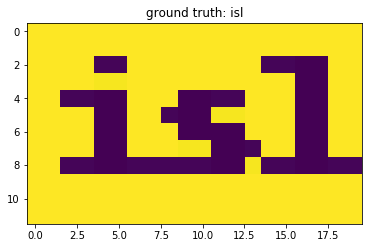

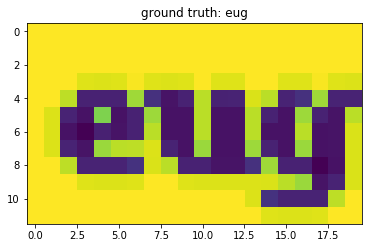

In [7]:
prior = model.prior_distribution()
sample = prior.sample()
plt.imshow(sample['image'].numpy().reshape(12,-1))
plt.title('ground truth: {}'.format(sample['word']))
plt.show()

sample = prior.sample()
plt.imshow(sample['image'].numpy().reshape(12,-1))
plt.title('ground truth: {}'.format(sample['word']))
plt.show()

## Learning the inference network


During inference we want to steer the simulator with a "smart ML agent" such that we only get samples that match our observed captcha. This way we can inspect the latent state of the sampled traces and quickly extract the solution.

We will now train the ML agent on 5000 traces.

In [8]:
model.learn_inference_network(
    num_traces=5000,
    observe_embeddings={'obs0': {'dim': 32, 'depth': 3}}
)

Creating new inference network...
Observable obs0: observe embedding not specified, using the default FEEDFORWARD.
Observe embedding dimension: 32
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Traces/sec
New layers, address: 16__forward__mu__Normal__1, distribution: Normal
New layers, address: 36__forward__blur__Normal__1, distribution: Normal
Total addresses: 2, parameters: 61,870
0d:00:00:07 | 1    | 5,056     | +1.44e+00 | +1.31e+00 | +1.32e+00 | 0d:00:00:00 | 617.0                              


## Sampling from the Posterior

Now we will generate the posterior distribution. `pyprob` will generate 10,000 weighted traces from which we can sample according to their weights, which gives us unweighted samples frmo the posterior.

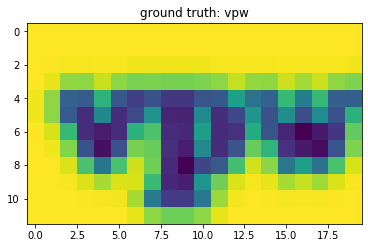

In [9]:
condition = prior.sample()
plt.imshow(condition['image'].numpy().reshape(12,-1))
plt.title('ground truth: {}'.format(condition['word']))
plt.show()

In [10]:
posterior = model.posterior_distribution(
    num_traces=10000,
    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
    observe={'obs0': condition['image'].numpy()}
)

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:00:53 | 0d:00:00:00 | #################### | 10000/10000 | 188.66       


## Making the Animations

Now that we have the prior and posterior distributions we can sample a few captchas to observe the effect of the conditioning on the above "observation"

We will draw 100 captchas each. If everything worked, the prior will be changing very rapidly while the posterior should almost always yield a CAPTCHA that looks much like the condition

In [12]:
for i in range(100):
    if i%10 == 0:
        print(i)
    sample = prior.sample()
    plt.imshow(sample['image'].reshape(12,-1))
    plt.title('generated {}'.format(sample['word']))
    plt.savefig('foranim_prior_{}.png'.format(str(i).zfill(6)))
plt.clf()
print('make animation')
uniq = time.time()
!convert -delay 5 -loop 0 foranim_prior_*.png prior_{uniq}.gif
!rm foranim_prior_*png
print('display image')
IPython.display.Image(url='prior_{}.gif'.format(uniq).format(uniq))

0
10
20
30
40
50
60
70
80
90
make animation
display image


<Figure size 432x288 with 0 Axes>

In [13]:
for i in range(100):
    if i%10 == 0:
        print(i)
    sample = posterior.sample()
    plt.imshow(sample['image'].reshape(12,-1))
    plt.title('ground truth: {}, generated: {}'.format(condition['word'],sample['word']))
    plt.savefig('foranim_posterior_{}.png'.format(str(i).zfill(6)))
plt.clf()
print('make animation')
uniq = time.time()
!convert -delay 5 -loop 0 foranim_posterior_*.png posterior_{uniq}.gif
!rm -rf foranim_posterior_*png
print('display image')
IPython.display.Image(url='posterior_{}.gif'.format(uniq))

0
10
20
30
40
50
60
70
80
90
make animation
display image


<Figure size 432x288 with 0 Axes>

## Inspecting the Latent State

For evey sample we draw from the posterior we have full access to the trace. We can e.g. construct marginal posterior  distributions for specific letters of the captcha

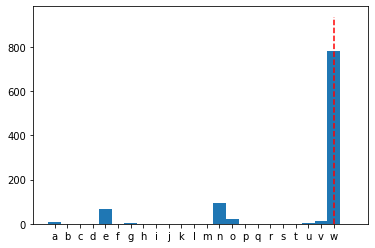

In [14]:
letter_num = 2

reverse_alphabet = {v:k for k,v in alphabet.items()} 
c,_,_ = plt.hist([reverse_alphabet[posterior.sample()['word'][letter_num]] for i in range(1000)], bins = np.linspace(-0.5,len(alphabet)+0.5,len(alphabet)+2))

plt.xticks(range(len(alphabetorder)),list(alphabetorder));
plt.vlines(reverse_alphabet[condition['word'][letter_num]],0,1.2*max(c), colors = 'r', linestyles = 'dashed')

## Solving the CAPTCHA

A good solution is the MAP, the maximum a posteriori value of the posterior. If we sample traces from the posterior and pick the solution which appears most often, it has a good chance to be the true solution

In [15]:
solutions, counts = np.unique([posterior.sample()['word'] for i in range(1000)], return_counts = True)
solutions[np.argmax(counts)]

'wpw'